In [ ]:
import pyomo.environ as pyo
import numpy as np
import polytope as pt
import matplotlib.pyplot as plt

def solve_cftoc(Q, N, x0, Ts, L, m, g):

  model = pyo.ConcreteModel()
  model.N = N
  model.nx = 8
  model.nu = 2
  
  # length of finite optimization problem:
  model.tIDX = pyo.Set( initialize= range(model.N+1), ordered=True )  
  model.xIDX = pyo.Set( initialize= range(model.nx), ordered=True )
  model.uIDX = pyo.Set( initialize= range(model.nu), ordered=True )
  

  model.Q = Q


  # Create state and input variables trajectory:
  model.x = pyo.Var(model.xIDX, model.tIDX)
  model.u = pyo.Var(model.uIDX, model.tIDX)

  #Objective: 
  def objective_rule(model):
    costX = 0.0
    # costU = 0.0
    # costTerminal = 0.0
    for t in model.tIDX:
        for i in model.xIDX:
            for j in model.xIDX:
                if t < model.N:
                    costX += model.x[i, t] * model.Q[i, j] * model.x[j, t] #xQx

    return costX
  
  model.cost = pyo.Objective(rule = objective_rule, sense = pyo.minimize)

    # Constraints:
  def equality_const_rule_1(model, t):
    return model.x[0, t+1] - model.x[0, t] - Ts*model.x[2, t] == 0.0 if t < model.N else pyo.Constraint.Skip

  def equality_const_rule_2(model, t):
    return model.x[1, t+1] - model.x[1, t] - Ts*model.x[3, t] == 0.0 if t < model.N else pyo.Constraint.Skip
    
  def equality_const_rule_3(model, t):
    return model.x[2, t+1] - model.x[2, t] == 0.0 if t < model.N else pyo.Constraint.Skip

  def equality_const_rule_4(model, t):
    return model.x[3, t+1] - model.x[3, t] - Ts*(- g)== 0.0 if t < model.N else pyo.Constraint.Skip
  
  def equality_const_rule_5(model, t):
    return model.x[4, t+1] - model.x[4, t] - Ts*model.x[6, t]== 0.0 if t < model.N else pyo.Constraint.Skip

  def equality_const_rule_6(model, t):
    return model.x[5, t+1] - model.x[5, t] - Ts*model.x[7, t]== 0.0 if t < model.N else pyo.Constraint.Skip

  def equality_const_rule_7(model, t):
    return model.x[6, t+1] - model.x[6, t] - Ts*model.u[0, t]== 0.0 if t < model.N else pyo.Constraint.Skip

  def equality_const_rule_8(model, t):
    return model.x[7, t+1] - model.x[7, t] - Ts*model.u[1, t]== 0.0 if t < model.N else pyo.Constraint.Skip


  # initial constraints
  model.init_const1 = pyo.Constraint(expr = model.x[0, 0] == x0[0])
  model.init_const2 = pyo.Constraint(expr = model.x[1, 0] == x0[1])
  model.init_const3 = pyo.Constraint(expr = model.x[2, 0] == x0[2])
  model.init_const4 = pyo.Constraint(expr = model.x[3, 0] == x0[3])
  model.init_const5 = pyo.Constraint(expr = model.x[4, 0] == x0[4])
  model.init_const6 = pyo.Constraint(expr = model.x[5, 0] == x0[5])
  model.init_const7 = pyo.Constraint(expr = model.x[6, 0] == x0[6])
  model.init_const8 = pyo.Constraint(expr = model.x[7, 0] == x0[7])
  
  # string constraint
  model.string_const = pyo.Constraint(model.tIDX, rule = lambda model, t: (model.x[0, t] - model.x[4, t])**2 + (model.x[1, t] - model.x[5, t])**2 <= L*L 
                                      if t < N+1 else pyo.Constraint.Skip)

  # system dynamics
  model.eq_const1 = pyo.Constraint(model.tIDX, rule = equality_const_rule_1)
  model.eq_const2 = pyo.Constraint(model.tIDX, rule = equality_const_rule_2)
  model.eq_const3 = pyo.Constraint(model.tIDX, rule = equality_const_rule_3)
  model.eq_const4 = pyo.Constraint(model.tIDX, rule = equality_const_rule_4)
  model.eq_const5 = pyo.Constraint(model.tIDX, rule = equality_const_rule_5)
  model.eq_const6 = pyo.Constraint(model.tIDX, rule = equality_const_rule_6)
  model.eq_const7 = pyo.Constraint(model.tIDX, rule = equality_const_rule_7)
  model.eq_const8 = pyo.Constraint(model.tIDX, rule = equality_const_rule_8)
  
  # terminal constraints

  model.term_const1 = pyo.Constraint(expr = model.x[0, N] - model.x[4, N] - 0.0001<= 0)
  model.term_const2 = pyo.Constraint(expr = model.x[4, N] - model.x[0, N] - 0.0001<= 0)
  model.term_const3 = pyo.Constraint(expr = model.x[1, N] - model.x[5, N] - 0.0001<= 0)
  model.term_const4 = pyo.Constraint(expr = model.x[5, N] - model.x[1, N] - 0.0001<= 0)
  model.term_const5 = pyo.Constraint(expr = model.x[2, N] - model.x[6, N] - 0.0001<= 0)
  model.term_const6 = pyo.Constraint(expr = model.x[6, N] - model.x[2, N] - 0.0001<= 0)
  model.term_const7 = pyo.Constraint(expr = model.x[3, N] - model.x[7, N] - 0.0001<= 0)
  model.term_const8 = pyo.Constraint(expr = model.x[7, N] - model.x[3, N] - 0.0001<= 0)



  solver = pyo.SolverFactory('ipopt')
  results = solver.solve(model)
  
  if str(results.solver.termination_condition) == "optimal":
      feas = True
  else:
      feas = False
          
  xOpt = np.asarray([[model.x[i,t]() for i in model.xIDX] for t in model.tIDX]).T
  uOpt = np.asarray([model.u[:,t]() for t in model.tIDX]).T
  
  JOpt = model.cost()
  
  return [feas, xOpt, uOpt, JOpt]

In [ ]:
from __future__ import division
import pyomo.environ as pyo
import numpy as np
import polytope as pt
import matplotlib.pyplot as plt

Q = np.array([[0, 0, 0, 0, 0, 0, 0, 0], 
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 0, 0, 1]])

N = 3
L = 0.36
x0 = np.array([0.232 , 0.274, -1.149, 0.971, 0, 0, 0, 0])
Ts = 0.01
m = 0.01
g = 9.8
# Xcup = 3
# Ycup = 3
nx = 8
nu = 2

M = 15
xOpt = np.zeros((nx, M+1))
uOpt = np.zeros((nu, M))
xOpt[:, 0] = x0.reshape(nx, )

xPred = np.zeros((nx, N+1, M))
predErr = np.zeros((nx, M-N+1))

feas = np.zeros((M, ), dtype=bool)

for t in range(M):
    [feas[t], x, u, J] = solve_cftoc(Q, N, xOpt[:, t], Ts, L, m, g)
    
    if not feas[t]:
        xOpt = []
        uOpt = []
        predErr = []
        print(feas)
        break
    

    xPred[:, :, t] = x
    
    
    xOpt[:, t+1] = x[:, 1]
    uOpt[:, t] = u[:, 0].reshape(nu, )


Text(0, 0.5, 'Y')

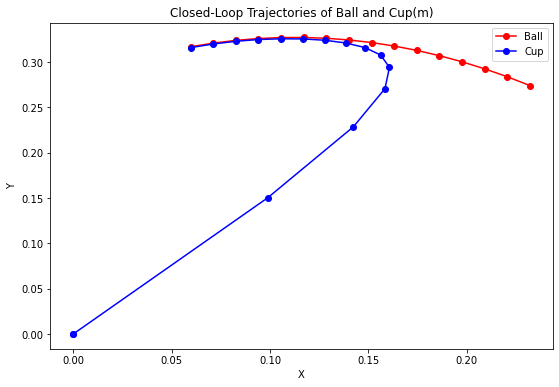

In [ ]:
fig1 = plt.figure(figsize=(9, 6))
ball_cp = plt.plot(xOpt[0, :], xOpt[1, :], 'ro-')
cup_cp = plt.plot(xOpt[4, :], xOpt[5, :], 'bo-')
plt.title('Closed-Loop Trajectories of Ball and Cup(m)')
plt.legend([ball_cp[0], cup_cp[0]], ['Ball', 'Cup']);
plt.xlabel('X')
plt.ylabel('Y')


Text(0, 0.5, 'a')

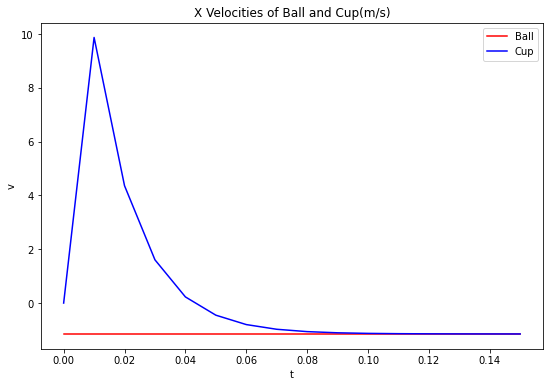

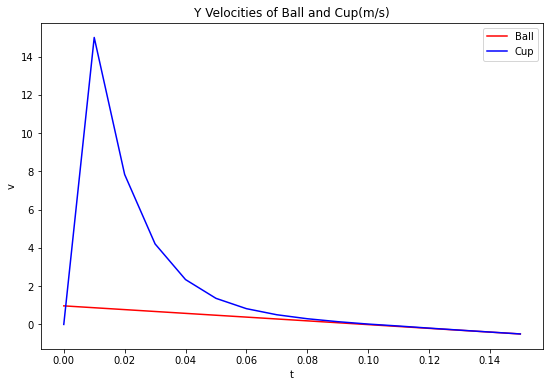

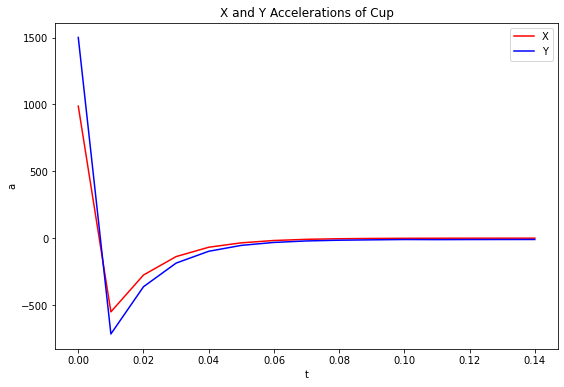

In [ ]:
T = np.asarray(range(M+1))*Ts

fig2 = plt.figure(figsize=(9, 6))
vball_x = plt.plot(T, xOpt[2, :], 'r-')
vcup_x = plt.plot(T, xOpt[6, :], 'b-')
plt.title('X Velocities of Ball and Cup(m/s)')
plt.legend([vball_x[0], vcup_x[0]], ['Ball', 'Cup']);
plt.xlabel('t')
plt.ylabel('v')


fig3 = plt.figure(figsize=(9, 6))
vball_y = plt.plot(T, xOpt[3, :], 'r-')
vcup_y = plt.plot(T, xOpt[7, :], 'b-')
plt.title('Y Velocities of Ball and Cup(m/s)')
plt.legend([vball_y[0], vcup_y[0]], ['Ball', 'Cup']);
plt.xlabel('t')
plt.ylabel('v')


Ta = np.asarray(range(M))*Ts
fig4 = plt.figure(figsize=(9, 6))
acup_x = plt.plot(Ta, uOpt[0, :], 'r-')
acup_y = plt.plot(Ta, uOpt[1, :], 'b-')
plt.title('X and Y Accelerations of Cup')
plt.legend([acup_x[0], acup_y[0]], ['X', 'Y']);
plt.xlabel('t')
plt.ylabel('a')
